In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import win32com.client
import sqlite3

import sys
from enum import Enum
import time
import pythoncom

import warnings
warnings.filterwarnings('ignore')

# matplotlib 그래프 한글지원
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False
if platform.system()== 'Windows':
    path= 'c:/Windows/Fonts/malgun.ttf'
    font_name= font_manager.FontProperties(fname=path).get_name()
    rc('font', family= font_name)
elif platform.system()=='Darwin':
    rc('font', family= 'AppleGothic')
else:
    print('포트를 지원하지 않습니다.')

In [2]:
import FinanceDataReader as fdr
fdr.__version__    

stock_code= '233740'
df_kospi = fdr.DataReader(stock_code, '2011') 
# 229200(코스닥) , 251340(코스닥인버스), 233740(코스닥 레버리지), 069500(KODEX 200), 122630(KODEX 레버리지)
print(df_kospi.shape)

(846, 6)


In [3]:
df_kospi.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2015-12-17,10240,10405,9970,10330,946156,NaN
2015-12-18,10230,10710,10165,10710,1841150,0.036786
2015-12-21,10695,10825,10670,10720,1274858,0.000934
2015-12-22,10740,10750,10450,10495,1374974,-0.020989
2015-12-23,10535,10635,10415,10425,2532341,-0.006670


In [4]:
df_kospi.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2019-05-29,10200,10225,9795,9845,17356813,-0.044639
2019-05-30,9870,10040,9710,9850,17496589,0.000508
2019-05-31,9780,10270,9725,10085,20403360,0.023858
2019-06-03,9990,10230,9945,10195,14911646,0.010907
2019-06-04,10150,10325,10135,10245,11931450,0.004904


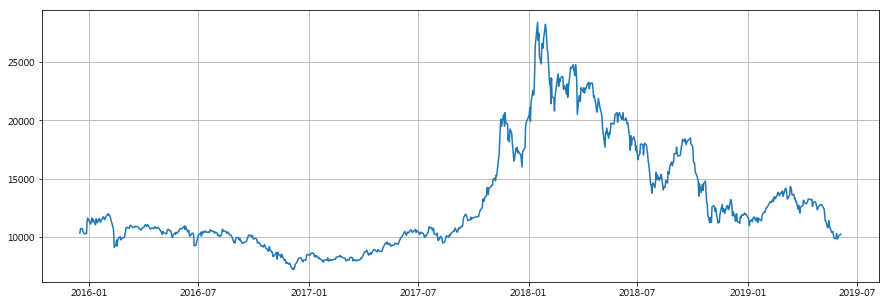

In [5]:
#df_graph= df.loc['20160302':'20181230']
df_graph= df_kospi.copy()
fig= plt.figure(figsize=(15,5))
ax1= fig.add_subplot(1,1,1)
ax1.plot(df_graph.index, df_graph['Close'])
ax1.grid()
plt.show()

- 기본 전략: 변동성 돌파 전략
- 매수 조건: 장중 가격 >= 당일 시가 + 전일 변동폭의 1/2
- 매수 가격: 당일 시가 + 전일 변동폭의 1/2 + 1호가
- 매도 조건: 익일 시가 - 1호가
- 거래 비용: 15.43% (거래 수수료 0.03%, 수익금에 대한 세금: 15.4%)
- 체결 오차(슬리피지): 1호가
- 거래 대상: 
    - KODEX 코스닥 150 (229200)
    - KODEX 코스닥 150 레버리지 (233740)
    - KODEX 코스닥 150 인버스 (251340)
- 연간 투입 자금: 1억 원 (수익금 재투자 또는 고정)
- 보유 종목수: 하루 1개 (한 종목에 몰빵)
- 백테스트 기간: 2016년 1월 4일 - 2019년 6월 4일
       
- 이것도 해보자!
    * 전일 종가보다 5일, 20일간 최고가를 돌파할 때와 눌림목을 줄 때가 매수 타이밍입니다.
    변동성 전략에 성공하신 후 거기에 추세추종 전략을 적용하시면 대형주와 중소형주 모두에 적용 가능합니다. 
    물론 두 전략의 베이스가 되는 지지와 저항(매수/매도 맥점)에 대한 좀 더 디테일한 부분과 한 단계 상위(^-^)의 개념을 장착하시면 마치 예정론과 같은 현상이 눈 앞에서 펼쳐지는 것을 경험하게 되실겁니다
        


In [6]:
df= df_kospi.copy()
df['변동폭'] = df['High']- df['Low']
df['돌파기준'] = df['Open'] + (df['변동폭'].shift(1))/2
df.dropna(inplace= True)
df['돌파기준'] = df['돌파기준'].astype(int)

In [7]:
# datetime을 문자열로 변환
df['일자']= df.index.strftime('%Y%m%d')
df.set_index('일자', inplace= True)
df.head()

,Open,High,Low,Close,Volume,Change,변동폭,돌파기준
일자,,,,,,,,
20151218,10230,10710,10165,10710,1841150,0.036786,545,10447
20151221,10695,10825,10670,10720,1274858,0.000934,155,10967
20151222,10740,10750,10450,10495,1374974,-0.020989,300,10817
20151223,10535,10635,10415,10425,2532341,-0.006670,220,10685
20151224,10480,10525,10290,10295,1536790,-0.012470,235,10590


In [8]:
df.shape

(845, 8)

In [9]:
# 함수구조를 2단계로 나누자.
# 전략실행-> buy(1), sell(-1), hold(0)로 구분 -> Trading Signal 컬럼생성
# -> Trading Signal 컬럼값을 바탕으로 백테스팅 실행

# 일정시간후 매도할때-> 매수시점후 시간경과 칼럼 추가해야
# 하루에 매수와 매도가 겹쳐나왔을때 -> TS신호를 2개의 칼럼 BUY,SELL로 구분
# -> buy(1,0), sell(0,1), hold(0,0)로 구분

def STRATEGY_Run(df_local=None):
    
    ts_list=[]
    time_count= 0
    
    for idate, row in df_local[['Open','High','Low','돌파기준']].iterrows():

        시가, 고가, 저가, 돌파기준 = row
        sell_signal= 0
        buy_signal= 0
        
        #매도 조건: 익일 시가
        매도조건 = time_count > 1
        if 매도조건== True:
            sell_signal= 1
            time_count= 0
        
        # 매수 조건: 장중 가격 >= 당일 시가 + 전일 변동폭의 1/2
        매수조건 = 고가 > 돌파기준
        if 매수조건== True:
            buy_signal= 1
            time_count= 1            
           
        ts_list.append([idate, buy_signal, sell_signal])
        
        if time_count > 0:
            time_count += 1   
   

    return pd.DataFrame(data=ts_list, columns=['일자','BUY','SELL'])

In [10]:
df_signal= STRATEGY_Run(df_local= df)
df_signal.set_index('일자', inplace=True)
print(df_signal.shape) # 647
#df= df.join(df_signal)
df= pd.merge(df, df_signal, on='일자', how='inner')


(845, 2)


In [11]:
df.head(10)

,Open,High,Low,Close,Volume,Change,변동폭,돌파기준,BUY,SELL
일자,,,,,,,,,,
20151218,10230,10710,10165,10710,1841150,0.036786,545,10447,1,0
20151221,10695,10825,10670,10720,1274858,0.000934,155,10967,0,1
20151222,10740,10750,10450,10495,1374974,-0.020989,300,10817,0,0
20151223,10535,10635,10415,10425,2532341,-0.006670,220,10685,0,0
20151224,10480,10525,10290,10295,1536790,-0.012470,235,10590,0,0
20151228,10290,10460,10210,10305,2172665,0.000971,250,10407,1,0
20151229,10360,11305,10310,11305,2660830,0.097040,995,10485,1,1
20151230,11410,11665,11370,11625,1997046,0.028306,295,11907,0,1
20160104,11740,11790,10910,11110,2897533,-0.044301,880,11887,0,0


In [12]:
df.tail()

,Open,High,Low,Close,Volume,Change,변동폭,돌파기준,BUY,SELL
일자,,,,,,,,,,
20190529,10200,10225,9795,9845,17356813,-0.044639,430,10422,0,1
20190530,9870,10040,9710,9850,17496589,0.000508,330,10085,0,0
20190531,9780,10270,9725,10085,20403360,0.023858,545,9945,1,0
20190603,9990,10230,9945,10195,14911646,0.010907,285,10262,0,1
20190604,10150,10325,10135,10245,11931450,0.004904,190,10292,1,0


In [13]:
# 백테스트 실행, 수정필요: 투자금고정
def BACKTEST_Run(df_local=None, 투자시작일=None, 투자종료일=None, 투자금=10000000, 투자금고정= True):
    
    df_local= df_local.loc[투자시작일:투자종료일]
    portfolio = []  # 매수시 [매수일, 매수가, 수량]
    거래결과 = [] # 매도시 [매수가, 매도가, 수익, 수익률]
    계좌평가결과 = [] # [일자, 현재가, 매수가, 매도가, 수량, 매수금액, 평가금액, 투자금, 총자산, BUY, SELL]
    예수금= 투자금

    for idate, row in df_local[['Open','Close','돌파기준','BUY','SELL']].iterrows():
        시가, 종가, 돌파기준, BUY, SELL = row
        매도가= 0
        매수가2= 0
        
        # 거래 비용: 15.43% (거래 수수료 0.03%, 수익금에 대한 세금: 15.4%)
        # 매수 가격: 당일 시가 + 전일 변동폭의 1/2
        # 매도 조건: 익일 시가
        # 호가 단위: 5원
        
        ############################################################## 매도
        if SELL==1 and len(portfolio) > 0:
            매도가 = 시가 - 5
            [매수일,매수가,수량] = portfolio
            수익 = int((매도가 * 수량) * (1-0.00015)) - int((매수가 * 수량) * (1+0.00015))
            수익률 = round(((매도가 - 매수가) / 매수가 *100 - 0.03), 2)  ## 추가
            예수금 = 예수금 + int((매도가 * 수량) * (1-0.00015))               
            portfolio = []           
            거래결과.append([idate, 매수가, 매도가, 수익, 수익률])        

        
        ############################################################## 매수
        if BUY == 1 and len(portfolio) == 0:
            매수가 = 돌파기준 + 5
            매수가2 = 돌파기준 + 5  ## 추가
            
            if (투자금고정 == True) and (투자금 < 예수금): 
                수량 = int(투자금 // (매수가*(1+0.00015))) 
                예수금 =  예수금 - int((매수가 * 수량) * (1+0.00015))
            else:
                수량 = int(예수금 // (매수가*(1+0.00015))) 
                예수금 = 예수금 - int((매수가 * 수량) * (1+0.00015))
           
            portfolio = [idate, 매수가, 수량] 
            
             
        # 매일 계좌 평가하여 기록
        ##############################################################
        if len(portfolio) > 0:
            [매수일,매수가,수량] = portfolio
            매수금액 = 매수가 * 수량 # 매수시점 가격기준 평가
            평가금액 = 종가 * 수량 # 금일 종가기준 평가
            총자산 = 평가금액 + 예수금
        else:
            매수가 = 0
            수량 = 0
            매수금액 = 0
            평가금액 = 0
            총자산 = 예수금 
            
        계좌평가결과.append([idate, 종가, 매수가2, 매도가, 수량, 매수금액, 평가금액, 예수금, 총자산, BUY, SELL])

        
    # 거래의 최종 결과
    if (len(df_local) > 0) :
        #거래결과.append([df_local.index[-1], 0, 0, 0, 0, 투자금])
        #거래결과 = pd.DataFrame(data=거래결과, columns=['일자','매수가','매도가','수량','수익','투자금'])
        거래결과 = pd.DataFrame(data=거래결과, columns=['일자','매수가','매도가','수익','수익률'])
        거래결과.set_index('일자', inplace=True)
        
        계좌평가결과 = pd.DataFrame(data=계좌평가결과, columns=['일자','현재가','매수가','매도가','수량','매수금액',                                                    
                                                                '평가금액','예수금','총자산','BUY','SELL'])
        
        계좌평가결과.set_index('일자', inplace=True)
    
        return (거래결과, 계좌평가결과)
    else:
        return (0, 0)

    

In [72]:
거래결과1, 계좌평가결과1= BACKTEST_Run(df_local=df, 투자시작일='20180101', 투자종료일='20191230', 투자금=10000000, 투자금고정= False)
거래결과2, 계좌평가결과2= BACKTEST_Run(df_local=df, 투자시작일='20180101', 투자종료일='20191230', 투자금=10000000, 투자금고정= True)

In [73]:
계좌평가결과1.head(30)

,현재가,매수가,매도가,수량,매수금액,평가금액,예수금,총자산,BUY,SELL
일자,,,,,,,,,,
20180102,20440,20307,0,492,9991044,10056480,7458,10063938,1,0
20180103,21085,21057,20655,482,10149474,10162970,17197,10180167,1,1
20180104,19935,0,21285,0,0,0,10275028,10275028,0,1
20180105,21495,20862,0,492,10264104,10575540,9385,10584925,1,0
20180108,22540,22300,21540,475,10592500,10706500,11387,10717887,1,1
20180109,22170,0,22615,0,0,0,10751900,10751900,0,1
20180110,22290,0,0,0,0,0,10751900,10751900,0,0
20180111,23960,22877,0,469,10729313,11237240,20978,11258218,1,0
20180112,26350,25000,23995,450,11250000,11857500,21257,11878757,1,1


In [74]:
계좌평가결과1.tail(30)

,현재가,매수가,매도가,수량,매수금액,평가금액,예수금,총자산,BUY,SELL
일자,,,,,,,,,,
20190422,13010,13137,0,1079,14174823,14037790,6069,14043859,1,0
20190423,12990,0,12995,0,0,0,14025570,14025570,0,1
20190424,12830,0,0,0,0,0,14025570,14025570,0,0
20190425,12610,0,0,0,0,0,14025570,14025570,0,0
20190426,12325,0,0,0,0,0,14025570,14025570,0,0
20190429,12690,12575,0,1115,14021125,14149350,2342,14151692,1,0
20190430,12745,0,12625,0,0,0,14077105,14077105,0,1
20190502,12775,12785,0,1100,14063500,14052500,11496,14063996,1,0
20190503,12780,12890,12730,1086,13998540,13879080,11756,13890836,1,1


In [75]:
계좌평가결과1['date']= pd.to_datetime(계좌평가결과1.index)
계좌평가결과2['date']= pd.to_datetime(계좌평가결과2.index)

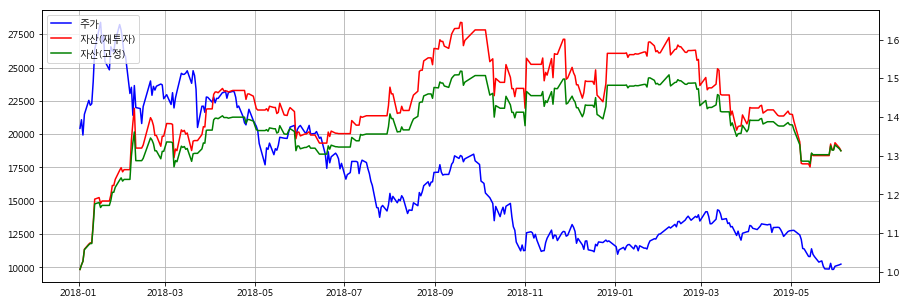

In [76]:
# 그래프 그리기
# 특정기간만 보기
df_graph1= 계좌평가결과1.loc['20150202':'20190830'].copy()
df_graph2= 계좌평가결과2.loc['20150202':'20190830'].copy()
fig= plt.figure(figsize=(15,5))

원금 = 10000000

ax1= fig.subplots()
ax2= ax1.twinx() # y축 2축 그래프 그리기
line1= ax1.plot(df_graph1['date'], df_graph1['현재가'], color='b', label='주가')
line2= ax2.plot(df_graph1['date'], (df_graph1['총자산'] - 원금 ) / 원금 + 1, color='r', label='자산(재투자)')
line3= ax2.plot(df_graph1['date'], (df_graph2['총자산'] - 원금 ) / 원금 + 1, color='g', label='자산(고정)')

# 축의 틱간격설정
# ax1.set_yticks(np.arange(-3, 3, step=0.25))
# ax2.set_yticks(np.arange(300, 3000, step=100))

# 축의 범위설정
# ax1.set_ylim(-1.75 , 2.5)
# ax2.set_ylim(500, 2600)

# 레이블 표시하기
lines= line1+line2+line3
labels= [l.get_label() for l in lines]
plt.legend(lines, labels, loc=2)

ax1.grid()
plt.show()


# ax1.plot(df_graph[df_graph['TS']==1]['date'], df_graph[df_graph['TS']==1]['매수가'], '^', color='r', label='buy')
# ax1.plot(df_graph[df_graph['TS']==-1]['date'], df_graph[df_graph['TS']==-1]['매도가'], '^', color='b', label='sell')



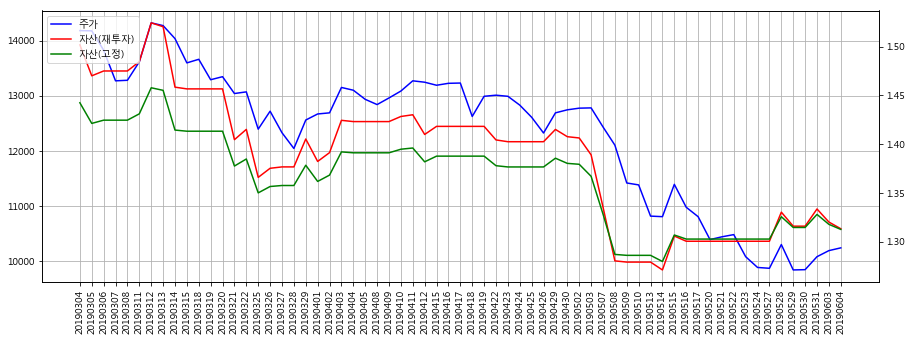

In [77]:
# 그래프 그리기
# 특정기간만 보기
df_graph1= 계좌평가결과1.loc['20190302':'20190830'].copy()
df_graph2= 계좌평가결과2.loc['20190302':'20190830'].copy()
fig= plt.figure(figsize=(15,5))

원금 = 10000000

# x축 틱설정
xticks= pd.date_range(start=df_graph1.index.min(), end=df_graph1.index.max(), freq='D')
xticks_name= [d for d in xticks.strftime('%y-%m-%d')]


ax1= fig.subplots()
line1= ax1.plot(df_graph1.index, df_graph1['현재가'], color='b', label='주가')
plt.xticks(xticks, xticks_name, rotation= 90)


ax2= ax1.twinx() # y축 2축 그래프 그리기
line2= ax2.plot(df_graph1.index, (df_graph1['총자산'] - 원금 ) / 원금 + 1, color='r', label='자산(재투자)')
line3= ax2.plot(df_graph1.index, (df_graph2['총자산'] - 원금 ) / 원금 + 1, color='g', label='자산(고정)')


#레이블 표시하기
lines= line1+line2+line3
labels= [l.get_label() for l in lines]
plt.legend(lines, labels, loc=2)

ax1.grid()
plt.show()



In [80]:
print('재투자')
print('==================')
print('거래횟수:',len(거래결과1), '/', len(계좌평가결과1))
print('수익: ', len(거래결과1['수익'][거래결과1['수익']>0]))
print('손실: ', len(거래결과1['수익'][거래결과1['수익']<0]))
print('보합: ', len(거래결과1['수익'][거래결과1['수익']== 0]))
print('수익합:', 거래결과1['수익'].sum(), '원')
print('수익률:', (거래결과1['수익'].sum()/원금)*100, '%')

재투자
거래횟수: 140 / 348
수익:  78
손실:  62
보합:  0
수익합: 3201018 원
수익률: 32.01018 %


In [81]:
print('고정')
print('==================')
print('거래횟수:',len(거래결과2), '/', len(계좌평가결과2))
print('수익: ', len(거래결과2['수익'][거래결과1['수익']>0]))
print('손실: ', len(거래결과2['수익'][거래결과1['수익']<0]))
print('보합: ', len(거래결과2['수익'][거래결과1['수익']== 0]))
print('수익합:', 거래결과2['수익'].sum(), '원')
print('수익률:', (거래결과2['수익'].sum()/원금)*100, '%')

고정
거래횟수: 140 / 348
수익:  78
손실:  62
보합:  0
수익합: 3177438 원
수익률: 31.77438 %


In [21]:
거래결과1.tail()

,매수가,매도가,수익,수익률
일자,,,,
20190328,6987,7060,126331,1.01
20190405,6867,6810,-108124,-0.86
20190408,6875,6830,-85359,-0.68
20190409,6887,6855,-61242,-0.49
20190410,6917,6860,-105197,-0.85


In [22]:
# 결과 csv 저장
계좌평가결과1.to_csv('./result_%s.csv'%(stock_code))


In [23]:
# 합성전략
df_1= pd.read_csv('./result_229200.csv', encoding='utf-8')
df_2= pd.read_csv('./result_251340.csv', encoding='utf-8')
df_1['일자'] = df_1['일자'].astype(str)
df_2['일자'] = df_2['일자'].astype(str)
df_1.set_index('일자', inplace=True)
df_2.set_index('일자', inplace=True)


In [24]:
df_1['date']= pd.to_datetime(df_1.index)
df_2['date']= pd.to_datetime(df_2.index)

In [25]:
df_2.tail()

,현재가,매수가,매도가,수량,매수금액,평가금액,예수금,총자산,BUY,SELL,date
일자,,,,,,,,,,,
20190405,6850,6875,6810,1814,12471250,12425900,869,12426769,1,1,2019-04-05
20190408,6870,6887,6830,1798,12382826,12352260,3947,12356207,1,1,2019-04-08
20190409,6840,6917,6855,1781,12319177,12182040,6364,12188404,1,1,2019-04-09
20190410,6805,0,6860,0,0,0,12222191,12222191,0,1,2019-04-10
20190411,6760,0,0,0,0,0,12222191,12222191,0,0,2019-04-11


In [176]:
df_1['합성']= (df_1['총자산']+df_2['총자산'])/2 

In [177]:
df_1.tail()

,현재가,매수가,매도가,수량,매수금액,평가금액,예수금,총자산,BUY,SELL,date,합성
일자,,,,,,,,,,,,
20190401,12165,12250,12095,1374,16831500,16714710,6658,16721368,1,1,2019-04-01,14651740.5
20190402,12180,0,12235,0,0,0,16815026,16815026,0,1,2019-04-02,14698569.5
20190403,12395,12242,0,1373,16808266,17018335,4239,17022574,1,0,2019-04-03,14802343.5
20190404,12375,0,12385,0,0,0,17006293,17006293,0,1,2019-04-04,14736499.0
20190405,12300,0,0,0,0,0,17006293,17006293,0,0,2019-04-05,14716531.0


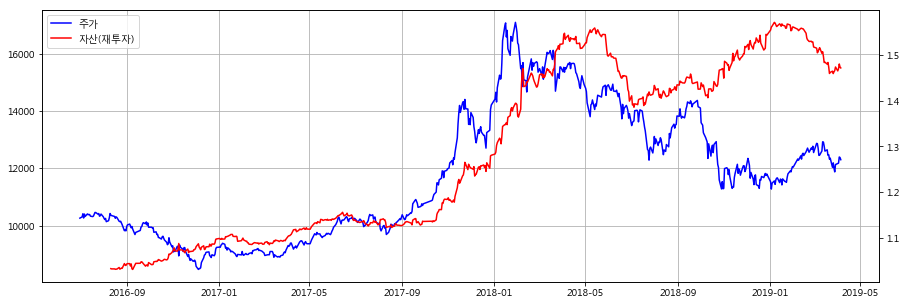

In [178]:
# 그래프 그리기
# 특정기간만 보기
df_graph= df_1.loc['20160701':'20190830'].copy()
fig= plt.figure(figsize=(15,5))

원금 = 10000000

ax1= fig.subplots()
ax2= ax1.twinx() # y축 2축 그래프 그리기
line1= ax1.plot(df_graph['date'], df_graph['현재가'], color='b', label='주가')
line2= ax2.plot(df_graph['date'], (df_graph['합성'] - 원금 ) / 원금 + 1, color='r', label='자산(재투자)')
#line3= ax2.plot(df_graph1['date'], (df_graph2['총자산'] - 원금 ) / 원금 + 1, color='g', label='자산(고정)')

# 축의 틱간격설정
# ax1.set_yticks(np.arange(-3, 3, step=0.25))
# ax2.set_yticks(np.arange(300, 3000, step=100))

# 축의 범위설정
# ax1.set_ylim(-1.75 , 2.5)
# ax2.set_ylim(500, 2600)

# 레이블 표시하기
lines= line1+line2
labels= [l.get_label() for l in lines]
plt.legend(lines, labels, loc=2)

ax1.grid()
plt.show()




In [ ]:
# MDD 등 리포트 작성
# 엑셀리포팅

In [ ]:
229200

2015.10~2015.12
거래횟수: 18 / 62
수익:  12
손실:  6
보합:  0
수익합: 698092 원
수익률합: 6.920000000000001 %

2016
거래횟수: 73 / 246
수익:  43
손실:  30
보합:  0
수익합: 1073773 원
수익률합: 10.46 %

2017
거래횟수: 96 / 243
수익:  65
손실:  31
보합:  0
수익합: 3622385 원
수익률합: 31.48 %

2018
거래횟수: 99 / 244
수익:  56
손실:  43
보합:  0
수익합: 1473673 원
수익률합: 14.879999999999999 %

2019.01~2019.04
거래횟수: 30 / 64
수익:  15
손실:  15
보합:  0
수익합: -173986 원
수익률합: -1.6199999999999994 %
    
 
    
251340

2016.08~2016.12
거래횟수: 47 / 96
수익:  26
손실:  21
보합:  0
수익합: 881454 원
수익률합: 8.639999999999999 %

2017
거래횟수: 89 / 243
수익:  42
손실:  47
보합:  0
수익합: -323015 원
수익률합: -3.0200000000000014 %

2018
거래횟수: 110 / 244
수익:  62
손실:  48
보합:  0
수익합: 2873748 원
수익률합: 26.7 %

2019.01~2019.04
거래횟수: 28 / 64
수익:  11
손실:  17
보합:  0
수익합: -797294 원
수익률합: -8.17 %